In [1]:
import numpy as np
from tqdm.auto import tqdm
from time import time
import copy
import random
import math


import ratinabox
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from ratinabox.Neurons import *
ratinabox.stylize_plots(); ratinabox.autosave_plots=False; ratinabox.figure_directory = "../figures/"

from ratinabox.contribs.ValueNeuron import ValueNeuron

%load_ext autoreload
%autoreload 2

/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_circular_boundary(radius=1, num_points=100, center=(0, 0)):
    """Creates a circular boundary as a list of points."""
    theta = np.linspace(0, 2 * np.pi, num_points, endpoint=True)
    boundary = [[center[0] + radius * np.cos(t), center[1] + radius * np.sin(t)] for t in theta]
    return boundary

In [3]:
# Define a circular environment
circle_boundary = create_circular_boundary(radius=.6, num_points=200)

# Initialize the Environment with a circular boundary
env = Environment(params={"boundary": circle_boundary})
env.object_colormap = 'tab10'

In [4]:
def create_circular_hole(center, radius, num_points=20):
    """Creates a circular hole as a list of points (polygon approximation)."""
    theta = np.linspace(0, 2 * np.pi, num_points, endpoint=True)
    hole = np.array([[center[0] + radius * np.cos(t), center[1] + radius * np.sin(t)] for t in theta])
    return hole

In [5]:
def generate_rectangular_holes(env, num_holes=177, board_radius=0.6, hole_radius=0.025):
    """Generates a specific number of holes evenly spaced inside a circular boundary using a rectangular grid pattern."""
    # Calculate the approximate number of rows and columns
    area_per_hole = (np.pi * board_radius**2) / num_holes
    grid_spacing = np.sqrt(area_per_hole)
    num_cols = int(np.sqrt(num_holes))
    num_rows = int(np.ceil(num_holes / num_cols))

    # Adjust grid spacing to fit the circular boundary
    x_spacing = (2 * board_radius) / num_cols
    y_spacing = (2 * board_radius) / num_rows

    holes = []
    num_holes_created = 0

    # Create holes in a rectangular grid
    for i in range(num_cols):
        for j in range(num_rows):
            if num_holes_created >= num_holes:
                break

            # Compute the candidate grid position
            x = -board_radius + (i + 0.5) * x_spacing
            y = -board_radius + (j + 0.5) * y_spacing

            # Ensure the hole is inside the circular boundary
            if np.sqrt(x**2 + y**2) + hole_radius < board_radius:
                # Add objects to environment
                if(i == 0 and j == 0):
                    env.add_object([x, y], type='new')
                else:
                    env.add_object([x, y], type='same')
                num_holes_created += 1


        

def set_random_holes_reward(env, num_rewards=3):
    holes = env.holes  # Assuming env.holes is a list of hole objects
    if len(holes) < num_rewards:
        raise ValueError("Not enough holes in the environment to set the specified number of rewards.")
    
    reward_hole_indices = np.random.choice(len(holes), num_rewards, replace=False)

    return reward_hole_indices

In [6]:
generate_rectangular_holes(env)
indices = set_random_holes_reward(env, num_rewards=3)

ValueError: Not enough holes in the environment to set the specified number of rewards.

In [ ]:

reward_positions = np.array([np.mean(env.holes[i], axis=0) for i in indices])
print(reward_positions)

[[ 0.00125     0.47142857]
 [ 0.37048077 -0.04285714]
 [ 0.18586538 -0.3       ]]


In [ ]:
# Parameters for the circle and gap
diameter = 1.2         # Circle diameter
radius = diameter / 2  # Circle radius (0.6)
gap = 0.1             # Gap from the circle edge to each object

# The radial distance from the center to each object
d = radius + gap       # 0.6 + 0.25 = 0.85

# Define the angles in degrees for the four diagonal directions
angles_degrees = [45, 135, 225, 315]

# Convert angles to radians
angles_radians = [math.radians(angle) for angle in angles_degrees]

# Compute the positions using polar to Cartesian conversion
positions = [(d * math.cos(theta), d * math.sin(theta)) for theta in angles_radians]

In [ ]:
def rotate_positions(positions, angle_degrees=90, center=(0, 0)):
    """
    Rotate a list of (x, y) positions by a given angle (in degrees) around a specified center.
    
    Parameters:
        positions (list of tuple): List of (x, y) positions.
        angle_degrees (float): The rotation angle in degrees (default is 90).
        center (tuple): The center (x, y) about which to rotate (default is (0,0)).
    
    Returns:
        list of tuple: New list of rotated (x, y) positions.
    """
    rad = math.radians(angle_degrees)
    cos_val = math.cos(rad)
    sin_val = math.sin(rad)
    cx, cy = center
    rotated = []
    
    for x, y in positions:
        # Translate so that the center is at the origin
        x_rel = x - cx
        y_rel = y - cy
        
        # Apply rotation
        new_x_rel = x_rel * cos_val - y_rel * sin_val
        new_y_rel = x_rel * sin_val + y_rel * cos_val
        
        # Translate back
        new_x = new_x_rel + cx
        new_y = new_y_rel + cy
        rotated.append((new_x, new_y))
    
    return rotated

In [ ]:
positons = rotate_positions(positions, 45)

The cheeseboard has dimensions of 1.2m diameter and has 177 food holes. These dimensions are based on those from the RL papers (most have the same ). 

In [ ]:
def add_objects_corners_shapes(env, positions):
    # Plot the computed object positions (as different shapes)
    ax.plot(positions[0][0], positions[0][1], 'r^', markersize=8)  # Red triangle-up
    ax.plot(positions[1][0], positions[1][1], 'rs', markersize=8)  # Red square
    ax.plot(positions[2][0], positions[2][1], 'ro', markersize=8)  # Red circle
    ax.plot(positions[3][0], positions[3][1], 'r^', markersize=8)  # Red triangle-up
    ax.plot(positions[3][0] + 0.05, positions[3][1] + 0.05, 'rs', markersize=8)  # Red square with offset
    ax.plot(positions[3][0] - 0.05, positions[3][1] - 0.05, 'ro', markersize=8)  # Red circle with offset

def add_objects_corners_colors(env, positions):
    # Plot the computed object positions (as different shapes)
    ax.plot(positions[0][0], positions[0][1], 'ro', markersize=8)  # Red triangle-up
    ax.plot(positions[1][0], positions[1][1], 'bo', markersize=8)  # Red square
    ax.plot(positions[2][0], positions[2][1], 'mo', markersize=8)  # Red circle
    ax.plot(positions[3][0], positions[3][1], 'yo', markersize=8)  # Red triangle-up

In [ ]:


def add_uniform_objects(env, dist = 0.6, gap = 0.05, num_objects = 32):

    d = dist + gap
    newangles_degrees = np.linspace(0, 360, num_objects, endpoint=False).tolist()
    newangles_radians = [math.radians(angle) for angle in newangles_degrees]
    newpositions = [(d * math.cos(theta), d * math.sin(theta)) for theta in newangles_radians]

    random.shuffle(newpositions) #look at numpy function to do this so that seed is reproducible


    env.add_object([newpositions[0][0], newpositions[0][1]], type='new')
    for i in range(1,10):
        env.add_object([newpositions[i][0], newpositions[i][1]], type='same')

    env.add_object([newpositions[10][0], newpositions[10][1]], type='new')
    for i in range(11,21):
        env.add_object([newpositions[i][0], newpositions[i][1]], type='same')

    env.add_object([newpositions[21][0], newpositions[21][1]], type='new')
    for i in range(22,32):
        env.add_object([newpositions[i][0], newpositions[i][1]], type='same')



#instead of holes we add objects of type 1 
#also instead of just plotting the objects, add the objects to rinB env 
#look in rat environment in examples for how to do this
#make the objects closer to the envrionment boundary
#also randomize the objects


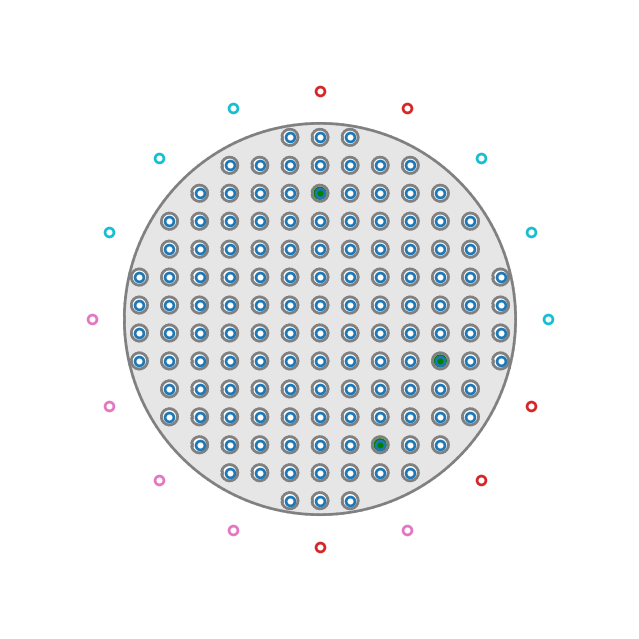

In [ ]:
# Plot the environment using the built-in function
fig, ax = env.plot_environment()

# Adjust the line width of the plotted elements
for line in ax.lines:
    line.set_linewidth(1.0)  # Set the desired line width for lines


# # Inspect and adjust the line width of the plotted elements
# for patch in ax.patches:
#     if np.allclose(patch.get_facecolor(), [1.0, 1.0, 1.0, 1.0]):  # Check if the patch is a hole (white color)
#         patch.set_edgecolor('black')  # Set the edge color to black
#         patch.set_linewidth(0.005)  # Set the desired line width for holes
#         patch.set_linestyle('-')  # Ensure the line style is solid
#     else:
#         patch.set_linewidth(1.0)  # Set the desired line width for other patches

for index in indices:
    ax.patches[index].set_facecolor('green')  # Set the face color of the reward holes to green

#add_objects_corners_colors(env, positions)
add_uniform_objects(env)
ax.set_xlim(ax.get_xlim()[0] - 0.3, ax.get_xlim()[1] + 0.3)  # Expand x-axis range
ax.set_ylim(ax.get_ylim()[0] - 0.3, ax.get_ylim()[1] + 0.3)  # Expand y-axis range

# Force a redraw of the plot
fig.canvas.draw()

# Display the updated plot
plt.show()

In [ ]:
#modify to have more objects, 2-4x more density 

In [ ]:
def make_rat_env(key):
    # TODO: think about how to make this more general
    if key == 'RiaB-LRoom':
        # Create the L-shaped environment
        Env = Environment(
                          params={"boundary": [[0,0],
                                               [0.625,0],
                                               [0.625,0.5],
                                               [1,0.5],
                                               [1,1],
                                               [0,1]],
                                  "dx": 1/16,
                                  "scale": 1}
                         )
        
        Env.object_colormap = 'brg'

        # Add floor marks
        for n in range(tri[0].size):
            if n==0:
                Env.add_object([arr[tri[0][n]+1],arr[tri[1][n]+9]], type='new')
            else:
                Env.add_object([arr[tri[0][n]+1],arr[tri[1][n]+9]], type='same')

        for n in range(plus[0].size):
            if n==0:
                Env.add_object([arr[plus[0][n]+9],arr[plus[1][n]+9]], type='new')
            else:
                Env.add_object([arr[plus[0][n]+9],arr[plus[1][n]+9]], type='same')

        for n in range(x[0].size):
            if n==0:
                Env.add_object([arr[x[0][n]+2],arr[x[1][n]+1]], type='new')
            else:
                Env.add_object([arr[x[0][n]+2],arr[x[1][n]+1]], type='same')
    
    return Env

In [ ]:
# Make the agent 
Ag = Agent(env)
Ag.dt = 50e-3  # set discretisation time, large is fine
Ag.episode_data = {
    "start_time": [],
    "end_time": [],
    "start_pos": [],
    "end_pos": [],
    "success_or_failure": [],
}  # a dictionary we will use later
Ag.exploit_explore_ratio = 0.3  # exploit/explore parameter we will use later

#Input features (200 place cells of random widths)
n_pc = 200 
Inputs = PlaceCells(
    Ag,
    params={
        "n": n_pc,
        "widths": np.random.uniform(0.04, 0.4, size=(n_pc)), #large and small widths
        "color": "C1",
        "wall_geometry": "euclidean",
    },
)


In [ ]:
print(reward_positions)

[[ 0.46278846  0.21428571]
 [ 0.27817308  0.04285714]
 [-0.09105769  0.3       ]]


In [ ]:
#The reward neuron (another place cell hidden behind the barrier) 
Reward = PlaceCells(
    Ag,
    params={
        "n": 3,
        "place_cell_centres": np.array(reward_positions),
        "description": "top_hat",
        "widths": 0.04,
        "max_fr": 1,
        "color": "C5",
        "wall_geometry": "euclidean",
    },
)
Reward.episode_end_time = 3  # a param we will use later

(<Figure size 1799.89x599.981 with 6 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

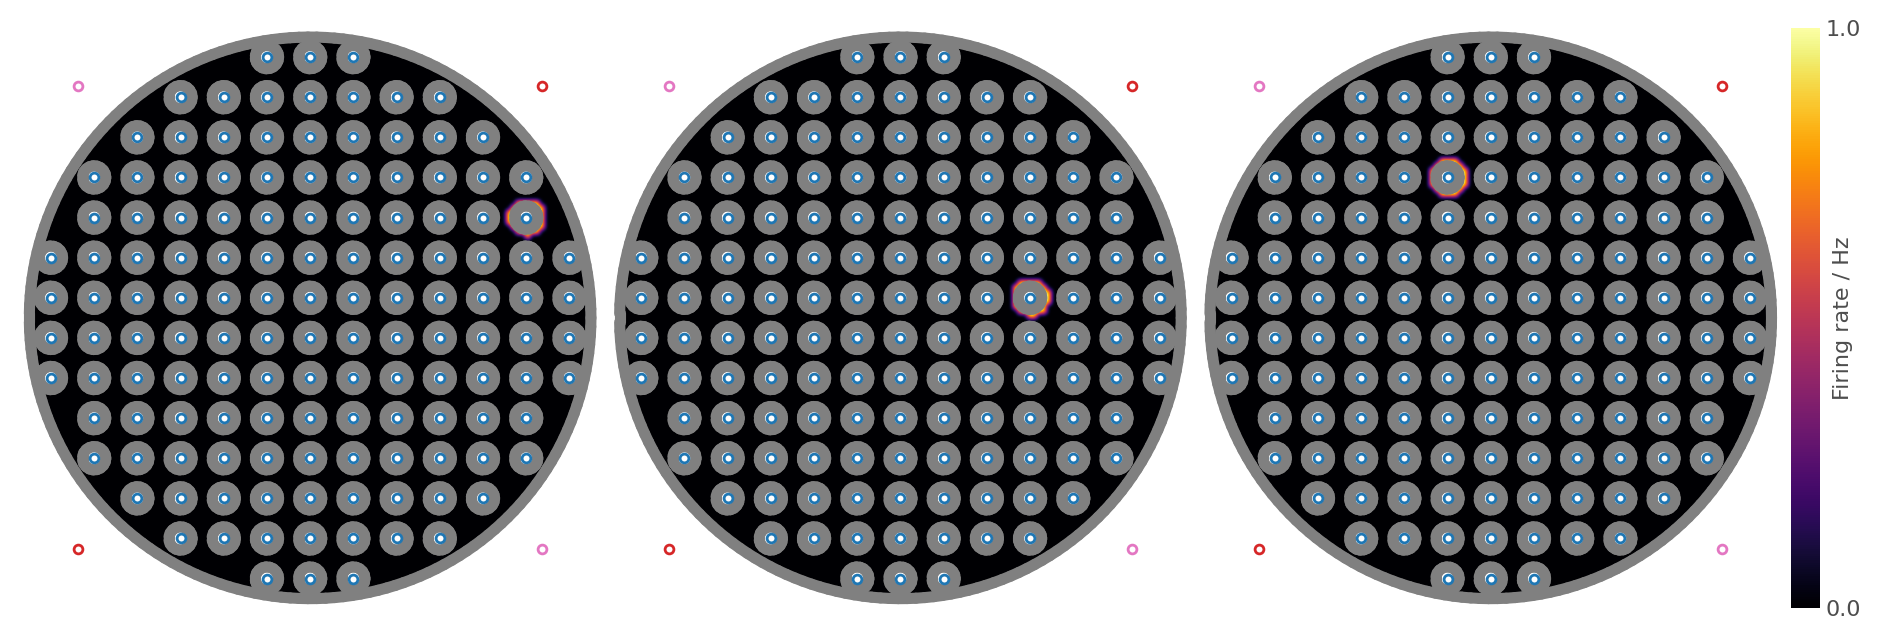

In [ ]:
Reward.plot_rate_map(chosen_neurons= [0,1,2])